---

## 1. OVERVIEW & METHODOLOGY

### 1.1 Purpose

**Phase 4: Spatial Block Cross-Validation Splits**

This notebook implements spatially disjoint train/validation/test splits to ensure robust model evaluation and prevent data leakage from spatial autocorrelation. The workflow creates 500×500m spatial blocks and assigns trees to splits using stratified group-based methods that maintain both genus class balance and spatial independence.

**Key Objectives:**
- Create regular 500×500m spatial grid blocks for each city
- Generate train/val splits for Hamburg and Berlin (80/20) using StratifiedGroupKFold
- Generate zero-shot test and fine-tuning evaluation splits for Rostock (80/20)
- Validate class balance and spatial separation across all splits
- Export comprehensive metadata for reproducibility

**Methodological Rationale:**
- **Spatial Block Cross-Validation:** Prevents inflated performance from spatial autocorrelation by ensuring train and validation blocks are spatially separated
- **StratifiedGroupKFold:** Maintains genus class balance while treating entire blocks as atomic units (no block can appear in both train and val)
- **Rostock Split Strategy:** 80% for zero-shot transfer testing (Experiment 2), 20% reserved for fine-tuning evaluation (Experiment 3)
- **Block Size Selection (500×500m):** Large enough to capture local variation, small enough to provide sufficient blocks for stratification

### 1.2 Workflow

```
[PHASE 1: SPATIAL BLOCK GENERATION]
├── Step 1.1: Load balanced tree datasets + city boundaries
├── Step 1.2: Create 500×500m grid blocks per city
├── Step 1.3: Assign block_id to each tree via spatial join
└── Step 1.4: Handle edge cases (trees outside blocks → nearest join)

    ↓

[PHASE 2: HAMBURG/BERLIN TRAIN/VAL SPLIT]
├── Step 2.1: Apply StratifiedGroupKFold (genus-stratified, block-grouped)
├── Step 2.2: Enforce 80/20 train/val ratio at block level
├── Step 2.3: Validate spatial separation (no overlapping blocks)
└── Step 2.4: Validate genus class distribution

    ↓

[PHASE 3: ROSTOCK ZERO-SHOT/FINE-TUNING SPLIT]
├── Step 3.1: Apply stratified random split (genus-balanced)
├── Step 3.2: Assign 80% blocks → zero-shot test
├── Step 3.3: Assign 20% blocks → fine-tuning evaluation
└── Step 3.4: Validate class balance and spatial coverage

    ↓

[PHASE 4: QUALITY CONTROL & VISUALIZATION]
├── Step 4.1: Compute split statistics (trees/blocks per genus)
├── Step 4.2: Visualize spatial distribution of splits
├── Step 4.3: Validate class balance across all splits
└── Step 4.4: Generate comprehensive validation reports

    ↓

[OUTPUT: Split datasets + metadata]
├── hamburg_train.gpkg, hamburg_val.gpkg
├── berlin_train.gpkg, berlin_val.gpkg
├── rostock_zero_shot.gpkg, rostock_finetune_eval.gpkg
├── block_assignments.csv (block → split mapping)
├── split_statistics.csv (trees/blocks per genus per split)
└── Visualizations (spatial maps + class distributions)
```

### 1.3 Expected Outputs

| File                         | Type       | Description                                                      |
| ---------------------------- | ---------- | ---------------------------------------------------------------- |
| hamburg_train.gpkg           | GeoPackage | Hamburg training set (~80% blocks, ~8,400 trees)                 |
| hamburg_val.gpkg             | GeoPackage | Hamburg validation set (~20% blocks, ~2,100 trees)               |
| berlin_train.gpkg            | GeoPackage | Berlin training set (~80% blocks, ~8,300 trees)                  |
| berlin_val.gpkg              | GeoPackage | Berlin validation set (~20% blocks, ~2,000 trees)                |
| rostock_zero_shot.gpkg       | GeoPackage | Rostock zero-shot test set (~80% blocks, ~6,500 trees)           |
| rostock_finetune_eval.gpkg   | GeoPackage | Rostock fine-tuning evaluation set (~20% blocks, ~1,500 trees)   |
| block_assignments.csv        | CSV        | Block-to-split mapping (city, block_id, split)                   |
| split_statistics.csv         | CSV        | Detailed statistics (trees/blocks per genus per split)           |
| spatial_splits_map.png       | PNG        | Visualization of spatial block distribution                      |
| class_balance_per_split.png  | PNG        | Genus distribution across all splits                             |

---

## 2. SETUP & IMPORTS

### 2.1 Packages & Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Core imports
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from pathlib import Path
from shapely.geometry import box, Point
from sklearn.model_selection import StratifiedGroupKFold
from collections import Counter

warnings.filterwarnings('ignore')

print("✓ Imports successful")

✓ Imports successful


### 2.2 Visualization & Utility Functions

In [3]:
# Publication-ready styling (consistent across all notebooks)
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (12, 7),
    'dpi_export': 300,
}

def setup_publication_style():
    """Configure matplotlib for publication-quality figures."""
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    print("✓ Publication Style configured")

setup_publication_style()

✓ Publication Style configured


In [4]:
# Utility functions

def create_spatial_blocks(gdf, block_size_m, city_name, boundary_geom=None):
    """
    Create regular grid of spatial blocks and assign block_id to each point.

    Args:
        gdf: GeoDataFrame with point geometries
        block_size_m: Block size in meters
        city_name: City name (for block_id prefix)
        boundary_geom: Optional Shapely geometry to define grid extent (ensures consistent grids)

    Returns:
        gdf_with_blocks: GeoDataFrame with new 'block_id' column
        blocks_gdf: GeoDataFrame with block polygons
        n_unassigned: Number of trees without initial block assignment
    """
    # Determine bounds: use boundary if provided, else data bounds
    if boundary_geom is not None:
        minx, miny, maxx, maxy = boundary_geom.bounds
    else:
        minx, miny, maxx, maxy = gdf.total_bounds

    # Create grid covering the extent
    x_coords = np.arange(minx, maxx, block_size_m)
    y_coords = np.arange(miny, maxy, block_size_m)

    blocks = []
    block_ids = []

    for i, x in enumerate(x_coords):
        for j, y in enumerate(y_coords):
            block_poly = box(x, y, x + block_size_m, y + block_size_m)
            blocks.append(block_poly)
            block_ids.append(f"{city_name}_{i}_{j}")

    blocks_gdf = gpd.GeoDataFrame(
        {'block_id': block_ids, 'geometry': blocks},
        crs=gdf.crs
    )

    # Spatial join: assign block_id to trees
    gdf_with_blocks = gpd.sjoin(
        gdf,
        blocks_gdf[['block_id', 'geometry']],
        how='left',
        predicate='within'
    )

    gdf_with_blocks = gdf_with_blocks.drop(columns=['index_right'], errors='ignore')
    # Ensure we don't duplicate trees (though sjoin within shouldn't unless blocks overlap)
    if 'tree_id' in gdf.columns:
        gdf_with_blocks = gdf_with_blocks.drop_duplicates(subset=['tree_id'], keep='first')
    else:
         gdf_with_blocks = gdf_with_blocks[~gdf_with_blocks.index.duplicated(keep='first')]

    # Handle trees without block assignment (edge cases)
    n_unassigned = gdf_with_blocks['block_id'].isna().sum()

    if n_unassigned > 0:
        # Nearest join for unassigned trees
        unassigned = gdf_with_blocks[gdf_with_blocks['block_id'].isna()].copy()
        assigned = gdf_with_blocks[~gdf_with_blocks['block_id'].isna()].copy()

        unassigned_fixed = gpd.sjoin_nearest(
            unassigned.drop(columns=['block_id']),
            blocks_gdf[['block_id', 'geometry']],
            how='left'
        )
        unassigned_fixed = unassigned_fixed.drop(columns=['index_right'], errors='ignore')

        gdf_with_blocks = pd.concat([assigned, unassigned_fixed], ignore_index=True)

    # Filter to blocks with trees (optional: keeps file size down)
    # We keep all blocks that have trees in THIS dataset
    occupied_blocks = gdf_with_blocks['block_id'].unique()
    blocks_gdf = blocks_gdf[blocks_gdf['block_id'].isin(occupied_blocks)].copy()

    return gdf_with_blocks, blocks_gdf, n_unassigned


def validate_split_separation(train_blocks, val_blocks):
    """
    Validate that train and validation blocks are disjoint.
    """
    overlap = set(train_blocks).intersection(set(val_blocks))
    return len(overlap) == 0


def compute_genus_distribution(gdf, genus_col='genus_latin'):
    """
    Compute genus distribution statistics.
    """
    return gdf[genus_col].value_counts().to_dict()


def plot_genus_distribution(splits_dict, viable_genera, title):
    """
    Plot genus distribution across multiple splits.
    """
    fig, ax = plt.subplots(figsize=(12, 7))

    x = np.arange(len(viable_genera))
    width = 0.8 / len(splits_dict)

    for i, (split_name, gdf) in enumerate(splits_dict.items()):
        counts = [gdf[gdf['genus_latin'] == genus].shape[0] for genus in viable_genera]
        offset = (i - len(splits_dict)/2 + 0.5) * width
        ax.bar(x + offset, counts, width, label=split_name,
               alpha=0.8, edgecolor='black', linewidth=0.8)

    ax.set_xlabel('Genus (Latin)', fontsize=12, weight='bold')
    ax.set_ylabel('Number of Trees', fontsize=12, weight='bold')
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(viable_genera, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig


print("✓ Utility functions defined")

✓ Utility functions defined


---

## 3. CONFIGURATION & PARAMETERS

### 3.1 Paths

In [5]:
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
DATA_DIR = BASE_DIR / 'data'
# Input path
INPUT_DATA_DIR = DATA_DIR / '02_pipeline' / '04_feature_reduction' / '05_outlier_detection' / 'data'
# Updated boundaries path
BOUNDARIES_DIR = DATA_DIR / '01_raw' / '01_boundaries'

# Output paths
OUTPUT_BASE_DIR = DATA_DIR / '02_pipeline' / '05_spatial_splits'
SPLITS_DATA_DIR = OUTPUT_BASE_DIR / 'data'
METADATA_DIR = OUTPUT_BASE_DIR / 'metadata'
PLOTS_DIR = OUTPUT_BASE_DIR / 'plots'

# Create output directories
SPLITS_DATA_DIR.mkdir(parents=True, exist_ok=True)
METADATA_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Input files
BOUNDARIES_PATH = BOUNDARIES_DIR / 'city_boundaries.gpkg'

print(f"✓ Base directory: {BASE_DIR}")
print(f"✓ Input data directory: {INPUT_DATA_DIR}")
print(f"✓ Boundaries directory: {BOUNDARIES_DIR}")
print(f"✓ Output Data directory: {SPLITS_DATA_DIR}")
print(f"✓ Output Metadata directory: {METADATA_DIR}")
print(f"✓ Output Plots directory: {PLOTS_DIR}")

✓ Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
✓ Input data directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/04_feature_reduction/05_outlier_detection/data
✓ Boundaries directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/01_raw/01_boundaries
✓ Output Data directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/data
✓ Output Metadata directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/metadata
✓ Output Plots directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/plots


### 3.2 Processing Parameters

In [6]:
# Processing configuration
PROCESSING_PARAMS = {
    # Cities to process
    'cities': ['Hamburg', 'Berlin', 'Rostock'],

    # Dataset variants
    'variants': ['no_edge', '20m_edge'],

    # Spatial block configuration
    'block_size_m': 500,  # 500×500m blocks

    # Split ratios
    'train_split': 0.8,   # 80% train, 20% val/test
    'n_folds': 5,         # Number of folds for StratifiedGroupKFold

    # Column names
    'genus_column': 'genus_latin',
    'tree_id_column': 'tree_id',

    # Random seed for reproducibility
    'random_state': 42,
}

# Derived parameters
CITIES = PROCESSING_PARAMS['cities']
VARIANTS = PROCESSING_PARAMS['variants']
BLOCK_SIZE_M = PROCESSING_PARAMS['block_size_m']
TRAIN_SPLIT = PROCESSING_PARAMS['train_split']
# VIABLE_GENERA will be set dynamically
RANDOM_STATE = PROCESSING_PARAMS['random_state']

# Display configuration
print("Processing Parameters:")
print("-" * 60)
for key, value in PROCESSING_PARAMS.items():
    print(f"  {key:<25} {str(value):<30}")
print("\n" + "=" * 60)
print(f"SPLIT CONFIGURATION: {int(TRAIN_SPLIT*100)}/{int((1-TRAIN_SPLIT)*100)} Train/Val")
print(f"VARIANTS: {VARIANTS}")
print("=" * 60)

Processing Parameters:
------------------------------------------------------------
  cities                    ['Hamburg', 'Berlin', 'Rostock']
  variants                  ['no_edge', '20m_edge']       
  block_size_m              500                           
  train_split               0.8                           
  n_folds                   5                             
  genus_column              genus_latin                   
  tree_id_column            tree_id                       
  random_state              42                            

SPLIT CONFIGURATION: 80/19 Train/Val
VARIANTS: ['no_edge', '20m_edge']


---

## 4. DATA LOADING

### 4.1 Load Input Datasets

In [8]:
print("\n" + "=" * 60)
print("LOADING INPUT DATASETS")
print("=" * 60)

# Dictionary to store trees: trees[variant][city]
trees = {v: {} for v in VARIANTS}
# Dictionary to store viable genera per variant
GENERA_PER_VARIANT = {}

# Input filenames mapping
variant_files = {
    'no_edge': 'trees_final_no_edge.gpkg',
    '20m_edge': 'trees_final_20m_edge.gpkg'
}

# Load datasets
for variant, filename in variant_files.items():
    filepath = INPUT_DATA_DIR / filename

    if not filepath.exists():
        raise FileNotFoundError(f"❌ Missing input file: {filepath}")

    print(f"\nLoading {variant} dataset ({filename})...")
    gdf_all = gpd.read_file(filepath)

    # Dynamically determine viable genera for this variant
    # Filter out None/NaN and sort
    unique_genera = sorted([g for g in gdf_all['genus_latin'].unique() if pd.notna(g)])
    GENERA_PER_VARIANT[variant] = unique_genera
    print(f"  ✓ Found {len(unique_genera)} genera: {unique_genera}")

    # Ensure city column exists
    if 'city' not in gdf_all.columns:
        raise ValueError(f"❌ 'city' column missing in {filename}")

    # Split by city
    for city in CITIES:
        # Filter for city (case-insensitive matching recommended if data varies)
        gdf_city = gdf_all[gdf_all['city'].astype(str) == city].copy()

        # Ensure tree_id exists
        if 'tree_id' not in gdf_city.columns:
            print(f"  ⚠️  Creating 'tree_id' for {city}...")
            gdf_city['tree_id'] = range(len(gdf_city))
            gdf_city['tree_id'] = f"{city}_{variant}_" + gdf_city['tree_id'].astype(str)

        trees[variant][city] = gdf_city
        print(f"  ✓ {city:10s}: {len(gdf_city):>6,} trees")

print("\n" + "=" * 60)
print("LOADING CITY BOUNDARIES")
print("=" * 60)

if not BOUNDARIES_PATH.exists():
    raise FileNotFoundError(f"❌ Missing boundaries file: {BOUNDARIES_PATH}")

boundaries = gpd.read_file(BOUNDARIES_PATH)

# Fix: Ensure 'city' column exists in boundaries
possible_name_cols = ['name', 'NAME', 'Name', 'stadt', 'Stadt', 'gen']
if 'city' not in boundaries.columns:
    found = False
    for col in possible_name_cols:
        if col in boundaries.columns:
            boundaries = boundaries.rename(columns={col: 'city'})
            print(f"  ⚠️  Renamed column '{col}' to 'city' in boundaries")
            found = True
            break
    if not found:
        print(f"  ⚠️  WARNING: Could not identify 'city' column automatically.")
        print(f"      Available columns: {boundaries.columns.tolist()}")

print(f"✓ Loaded boundaries: {len(boundaries)} cities")

print("\n✓ All data successfully loaded")


LOADING INPUT DATASETS

Loading no_edge dataset (trees_final_no_edge.gpkg)...
  ✓ Found 13 genera: ['ACER', 'AESCULUS', 'ALNUS', 'BETULA', 'CARPINUS', 'FAGUS', 'FRAXINUS', 'POPULUS', 'PRUNUS', 'QUERCUS', 'ROBINIA', 'SORBUS', 'TILIA']
  ✓ Hamburg   : 89,196 trees
  ✓ Berlin    : 509,683 trees
  ✓ Rostock   : 36,809 trees

Loading 20m_edge dataset (trees_final_20m_edge.gpkg)...
  ✓ Found 6 genera: ['ACER', 'BETULA', 'FRAXINUS', 'QUERCUS', 'SORBUS', 'TILIA']
  ✓ Hamburg   : 44,211 trees
  ✓ Berlin    : 165,204 trees
  ✓ Rostock   : 12,368 trees

LOADING CITY BOUNDARIES
  ⚠️  Renamed column 'gen' to 'city' in boundaries
✓ Loaded boundaries: 3 cities

✓ All data successfully loaded


### 4.2 Data Validation

In [9]:
print("\nData Validation:")
print("-" * 60)

for variant in VARIANTS:
    print(f"\nChecking {variant}...")
    for city, gdf in trees[variant].items():
        if len(gdf) == 0:
             print(f"⚠️  {city}: No trees found!")
             continue

        # Check required columns
        required_cols = [PROCESSING_PARAMS['genus_column']]
        missing_cols = [col for col in required_cols if col not in gdf.columns]

        if missing_cols:
            raise ValueError(f"❌ Missing columns in {variant}/{city}: {missing_cols}")

        # Check for missing values
        missing_genus = gdf[PROCESSING_PARAMS['genus_column']].isna().sum()
        if missing_genus > 0:
            print(f"⚠️  {city}: {missing_genus} trees with missing genus label")

        # Check CRS
        if gdf.crs is None:
            raise ValueError(f"❌ Missing CRS in {variant}/{city}")

        print(f"✓ {city}: Schema valid, CRS={gdf.crs.to_epsg()}")

print("-" * 60)
print("✓ Data validation complete")


Data Validation:
------------------------------------------------------------

Checking no_edge...
✓ Hamburg: Schema valid, CRS=25832
✓ Berlin: Schema valid, CRS=25832
✓ Rostock: Schema valid, CRS=25832

Checking 20m_edge...
✓ Hamburg: Schema valid, CRS=25832
✓ Berlin: Schema valid, CRS=25832
✓ Rostock: Schema valid, CRS=25832
------------------------------------------------------------
✓ Data validation complete


---

## 5. MAIN PROCESSING

### 5.1 Spatial Block Generation

In [10]:
print("\n" + "=" * 60)
print("PHASE 1: SPATIAL BLOCK GENERATION")
print("=" * 60)

trees_with_blocks = {v: {} for v in VARIANTS}
blocks_gdf = {v: {} for v in VARIANTS}

for city in CITIES:
    print(f"\nProcessing {city}...")

    # Get city boundary for consistent grid
    city_boundary = boundaries[boundaries['city'] == city].geometry.iloc[0] if not boundaries[boundaries['city'] == city].empty else None

    for variant in VARIANTS:
        gdf = trees[variant][city]
        if len(gdf) == 0: continue

        gdf_blocks, blocks, n_unassigned = create_spatial_blocks(
            gdf,
            BLOCK_SIZE_M,
            city,
            boundary_geom=city_boundary
        )

        trees_with_blocks[variant][city] = gdf_blocks
        blocks_gdf[variant][city] = blocks

        n_blocks = gdf_blocks['block_id'].nunique()
        print(f"  [{variant}] {n_blocks} blocks created ({n_unassigned} edge cases fixed)")

print("\n" + "=" * 60)
print("✓ Spatial block generation complete")
print("=" * 60)


PHASE 1: SPATIAL BLOCK GENERATION

Processing Hamburg...
  [no_edge] 2095 blocks created (0 edge cases fixed)
  _edge] 1986 blocks created (0 edge cases fixed)

Processing Berlin...
  [no_edge] 3021 blocks created (0 edge cases fixed)
  _edge] 2932 blocks created (0 edge cases fixed)

Processing Rostock...
  [no_edge] 414 blocks created (0 edge cases fixed)
  _edge] 379 blocks created (0 edge cases fixed)

✓ Spatial block generation complete


### 5.2 Hamburg/Berlin: Train/Val Split (StratifiedGroupKFold)

In [11]:
print("\n" + "=" * 60)
print("PHASE 2: HAMBURG/BERLIN TRAIN/VAL SPLIT")
print("=" * 60)

sgkf = StratifiedGroupKFold(
    n_splits=PROCESSING_PARAMS['n_folds'],
    shuffle=True,
    random_state=RANDOM_STATE
)

splits = {} # Flat dictionary for exports

for city in ['Hamburg', 'Berlin']:
    print(f"\n{city}:")
    for variant in VARIANTS:
        gdf = trees_with_blocks[variant][city]
        if len(gdf) == 0: continue

        # Prepare data for SGKF
        block_data = gdf.groupby('block_id').agg({
            'genus_latin': lambda x: x.mode()[0]
        }).reset_index()

        X = block_data['block_id'].values
        y = block_data['genus_latin'].values
        groups = block_data['block_id'].values

        # Get first fold
        try:
            train_idx, val_idx = next(sgkf.split(X, y, groups))
        except ValueError as e:
            print(f"  ⚠️ Skipping {city} {variant} due to error (too few samples?): {e}")
            continue

        train_blocks = set(X[train_idx])
        val_blocks = set(X[val_idx])

        train_trees = gdf[gdf['block_id'].isin(train_blocks)].copy()
        val_trees = gdf[gdf['block_id'].isin(val_blocks)].copy()

        # Store splits
        base_name = f"{city}_{variant}"
        splits[f'{base_name}_train'] = train_trees
        splits[f'{base_name}_val'] = val_trees
        splits[f'{base_name}_train_blocks'] = train_blocks
        splits[f'{base_name}_val_blocks'] = val_blocks

        print(f"  [{variant}] Train: {len(train_trees):>5,} | Val: {len(val_trees):>5,} | Val Ratio: {len(val_trees)/len(gdf):.1%}")

print("\n" + "=" * 60)
print("✓ Hamburg/Berlin splits complete")
print("=" * 60)


PHASE 2: HAMBURG/BERLIN TRAIN/VAL SPLIT

Hamburg:
  [no_edge] Train: 70,683 | Val: 18,513 | Val Ratio: 20.8%
  _edge] Train: 35,468 | Val: 8,743 | Val Ratio: 19.8%

Berlin:
  [no_edge] Train: 404,497 | Val: 105,186 | Val Ratio: 20.6%
  _edge] Train: 131,317 | Val: 33,887 | Val Ratio: 20.5%

✓ Hamburg/Berlin splits complete


### 5.3 Rostock: Zero-Shot Test / Fine-Tuning Eval Split

In [12]:
print("\n" + "=" * 60)
print("PHASE 3: ROSTOCK ZERO-SHOT/FINE-TUNING SPLIT")
print("=" * 60)

# Custom splitter for Rostock to achieve 30/70 split
# We use 10 folds and select 3 folds for the 30% Zero-Shot set
n_splits_rostock = 10
n_folds_zs = 3 # 30%

sgkf_rostock = StratifiedGroupKFold(
    n_splits=n_splits_rostock,
    shuffle=True,
    random_state=RANDOM_STATE
)

for variant in VARIANTS:
    gdf = trees_with_blocks[variant].get('Rostock')
    if gdf is None or len(gdf) == 0: continue

    block_data = gdf.groupby('block_id').agg({
        'genus_latin': lambda x: x.mode()[0]
    }).reset_index()

    X = block_data['block_id'].values
    y = block_data['genus_latin'].values
    groups = block_data['block_id'].values

    # Generate splits
    folds = list(sgkf_rostock.split(X, y, groups))

    # Collect indices for Zero-Shot (30% -> first 3 folds)
    zs_indices = []
    for i in range(n_folds_zs):
        _, test_idx = folds[i] # test_idx is the 10% chunk
        zs_indices.extend(test_idx)

    # Convert to sets
    zs_blocks = set(X[zs_indices])

    # Fine-Tuning is the rest (70%)
    all_blocks = set(X)
    ft_blocks = all_blocks - zs_blocks

    zs_trees = gdf[gdf['block_id'].isin(zs_blocks)].copy()
    ft_trees = gdf[gdf['block_id'].isin(ft_blocks)].copy()

    splits[f'rostock_{variant}_zero_shot'] = zs_trees
    splits[f'rostock_{variant}_finetune_eval'] = ft_trees
    splits[f'rostock_{variant}_zs_blocks'] = zs_blocks
    splits[f'rostock_{variant}_ft_blocks'] = ft_blocks

    # Stats
    total = len(gdf)
    zs_pct = len(zs_trees) / total * 100 if total > 0 else 0
    ft_pct = len(ft_trees) / total * 100 if total > 0 else 0

    print(f"Rostock [{variant}]:")
    print(f"  Zero-Shot (Target 30%): {len(zs_trees):>5,} trees ({zs_pct:.1f}%) | {len(zs_blocks)} blocks")
    print(f"  Fine-Tune (Target 70%): {len(ft_trees):>5,} trees ({ft_pct:.1f}%) | {len(ft_blocks)} blocks")

print("\n" + "=" * 60)
print("✓ Rostock splits complete")
print("=" * 60)


PHASE 3: ROSTOCK ZERO-SHOT/FINE-TUNING SPLIT
Rostock [no_edge]:
  Zero-Shot (Target 30%): 9,800 trees (26.6%) | 124 blocks
  Fine-Tune (Target 70%): 27,009 trees (73.4%) | 290 blocks
Rostock _edge]:
  Zero-Shot (Target 30%): 3,596 trees (29.1%) | 114 blocks
  Fine-Tune (Target 70%): 8,772 trees (70.9%) | 265 blocks

✓ Rostock splits complete


### 5.4 Quality Control: Class Balance Validation

In [13]:
print("\n" + "=" * 60)
print("PHASE 4: CLASS BALANCE VALIDATION")
print("=" * 60)

# Check a subset of splits (e.g. 20m_edge)
variant_to_check = '20m_edge'
print(f"\nDisplaying Class Balance for '{variant_to_check}' variant:")

keys_to_check = [
    f'Hamburg_{variant_to_check}_train',
    f'Hamburg_{variant_to_check}_val',
    f'rostock_{variant_to_check}_zero_shot'
]

for key in keys_to_check:
    if key not in splits: continue
    print(f"\n{key}:")
    gdf = splits[key]

    # Determine variant from key to get correct genera list
    variant = 'no_edge' if 'no_edge' in key else '20m_edge' if '20m_edge' in key else None
    if variant:
        current_genera = GENERA_PER_VARIANT.get(variant, [])
    else:
        current_genera = [] # Should not happen

    genus_counts = compute_genus_distribution(gdf)
    for genus in current_genera:
        count = genus_counts.get(genus, 0)
        pct = (count / len(gdf)) * 100 if len(gdf) > 0 else 0
        print(f"  {genus:12s}: {count:>5} ({pct:>5.1f}%)")


PHASE 4: CLASS BALANCE VALIDATION

Displaying Class Balance for '20m_edge' variant:

Hamburg_20m_edge_train:
  ACER        :  5422 ( 15.3%)
  BETULA      :  1577 (  4.4%)
  FRAXINUS    :   906 (  2.6%)
  QUERCUS     : 11945 ( 33.7%)
  SORBUS      :  1302 (  3.7%)
  TILIA       : 14316 ( 40.4%)

Hamburg_20m_edge_val:
  ACER        :  1389 ( 15.9%)
  BETULA      :   406 (  4.6%)
  FRAXINUS    :   289 (  3.3%)
  QUERCUS     :  2776 ( 31.8%)
  SORBUS      :   323 (  3.7%)
  TILIA       :  3560 ( 40.7%)

rostock_20m_edge_zero_shot:
  ACER        :   851 ( 23.7%)
  BETULA      :   522 ( 14.5%)
  FRAXINUS    :   222 (  6.2%)
  QUERCUS     :   295 (  8.2%)
  SORBUS      :   201 (  5.6%)
  TILIA       :  1505 ( 41.9%)


---

## 6. RESULTS & OUTPUTS

### 6.1 Split Statistics Summary

In [14]:
print("\n" + "=" * 60)
print("SPLIT STATISTICS SUMMARY")
print("=" * 60)

statistics = []

for split_name, gdf in splits.items():
    if 'blocks' in split_name: continue # Skip block sets

    # Determine variant for this split
    variant = 'no_edge' if 'no_edge' in split_name else '20m_edge' if '20m_edge' in split_name else None
    current_genera = GENERA_PER_VARIANT.get(variant, [])

    total_trees = len(gdf)
    n_blocks = gdf['block_id'].nunique()
    genus_counts = gdf['genus_latin'].value_counts()

    for genus in current_genera:
        count = genus_counts.get(genus, 0)
        statistics.append({
            'split': split_name,
            'genus': genus,
            'n_trees': count,
            'n_blocks': n_blocks,
            'total_trees': total_trees,
            'genus_pct': round((count / total_trees) * 100, 2) if total_trees > 0 else 0
        })

statistics_df = pd.DataFrame(statistics)

# Save statistics
stats_path = METADATA_DIR / 'split_statistics.csv'
statistics_df.to_csv(stats_path, index=False)
print(f"\n✓ Saved: {stats_path.name}")

# Display preview
print(statistics_df.groupby('split')[['n_trees', 'n_blocks']].first().to_string())


SPLIT STATISTICS SUMMARY

✓ Saved: split_statistics.csv
                                n_trees  n_blocks
split                                            
Berlin_20m_edge_train             34228      2345
Berlin_20m_edge_val                8021       587
Berlin_no_edge_train             108456      2416
Berlin_no_edge_val                28628       605
Hamburg_20m_edge_train             5422      1588
Hamburg_20m_edge_val               1389       398
Hamburg_no_edge_train             10455      1675
Hamburg_no_edge_val                2990       420
rostock_20m_edge_finetune_eval     1997       265
rostock_20m_edge_zero_shot          851       114
rostock_no_edge_finetune_eval      5540       290
rostock_no_edge_zero_shot          2080       124


### 6.2 Export Split Datasets

In [15]:
print("\n" + "=" * 60)
print("EXPORTING SPLIT DATASETS")
print("=" * 60)

for split_name, gdf in splits.items():
    if 'blocks' in split_name: continue

    # Generate filename: e.g. hamburg_no_edge_train.gpkg
    # Current keys: Hamburg_no_edge_train, rostock_no_edge_zero_shot
    filename = f"{split_name.lower()}.gpkg"

    output_path = SPLITS_DATA_DIR / filename
    gdf.to_file(output_path, driver='GPKG')
    print(f"✓ Saved {filename:40s} ({len(gdf):>5,} trees)")

print("\n✓ All split datasets exported")


EXPORTING SPLIT DATASETS
✓ Saved hamburg_no_edge_train.gpkg               (70,683 trees)
✓ Saved hamburg_no_edge_val.gpkg                 (18,513 trees)
✓ Saved hamburg_20m_edge_train.gpkg              (35,468 trees)
✓ Saved hamburg_20m_edge_val.gpkg                (8,743 trees)
✓ Saved berlin_no_edge_train.gpkg                (404,497 trees)
✓ Saved berlin_no_edge_val.gpkg                  (105,186 trees)
✓ Saved berlin_20m_edge_train.gpkg               (131,317 trees)
✓ Saved berlin_20m_edge_val.gpkg                 (33,887 trees)
✓ Saved rostock_no_edge_zero_shot.gpkg           (9,800 trees)
✓ Saved rostock_no_edge_finetune_eval.gpkg       (27,009 trees)
✓ Saved rostock_20m_edge_zero_shot.gpkg          (3,596 trees)
✓ Saved rostock_20m_edge_finetune_eval.gpkg      (8,772 trees)

✓ All split datasets exported


### 6.3 Export Block Assignments

In [16]:
print("\n" + "=" * 60)
print("EXPORTING BLOCK ASSIGNMENTS")
print("=" * 60)

block_assignments = []

for key, blocks in splits.items():
    if '_blocks' not in key: continue

    # Parse key: e.g. Hamburg_no_edge_train_blocks
    parts = key.split('_')

    # Identify city
    city = parts[0]

    # Identify variant
    if 'no_edge' in key: variant = 'no_edge'
    elif '20m_edge' in key: variant = '20m_edge'
    else: variant = 'unknown'

    # Identify split type
    if 'train' in key: split_type = 'train'
    elif 'val' in key: split_type = 'val'
    elif 'zero_shot' in key: split_type = 'zero_shot'
    elif 'finetune_eval' in key: split_type = 'finetune_eval'
    else: split_type = 'other'

    for block_id in blocks:
        block_assignments.append({
            'city': city,
            'variant': variant,
            'block_id': block_id,
            'split': split_type
        })

block_assignments_df = pd.DataFrame(block_assignments)
assignments_path = METADATA_DIR / 'block_assignments.csv'
block_assignments_df.to_csv(assignments_path, index=False)

print(f"✓ Saved: {assignments_path.name}")
print(f"  Total block records: {len(block_assignments_df):,}")


EXPORTING BLOCK ASSIGNMENTS
✓ Saved: block_assignments.csv
  Total block records: 10,827


### 6.4 Visualizations

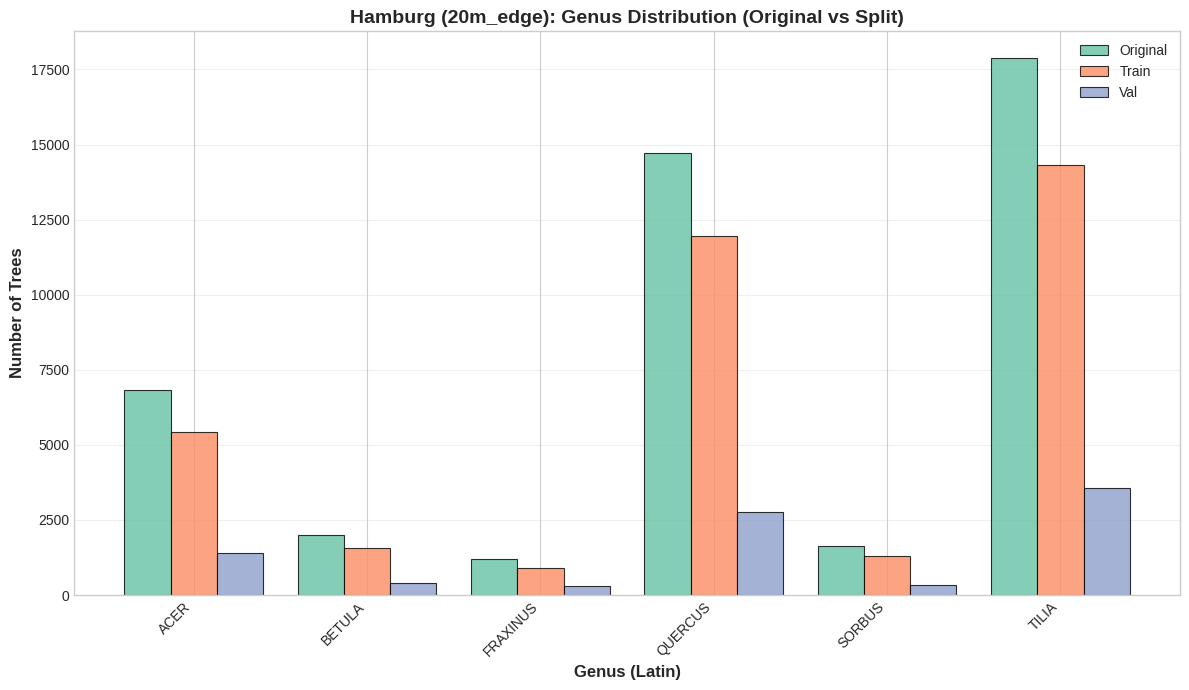

In [17]:
# Visualization 1: Class Balance for 20m_edge (High Quality)
variant = '20m_edge'

if f'Hamburg_{variant}_train' in splits:
    # Get original data for comparison
    original_gdf = trees[variant]['Hamburg']

    fig = plot_genus_distribution(
        {
            'Original': original_gdf,
            'Train': splits[f'Hamburg_{variant}_train'],
            'Val': splits[f'Hamburg_{variant}_val']
        },
        GENERA_PER_VARIANT[variant],
        f'Hamburg ({variant}): Genus Distribution (Original vs Split)'
    )
    plt.savefig(PLOTS_DIR / f'hamburg_{variant}_class_balance.png', bbox_inches='tight')
    plt.show()

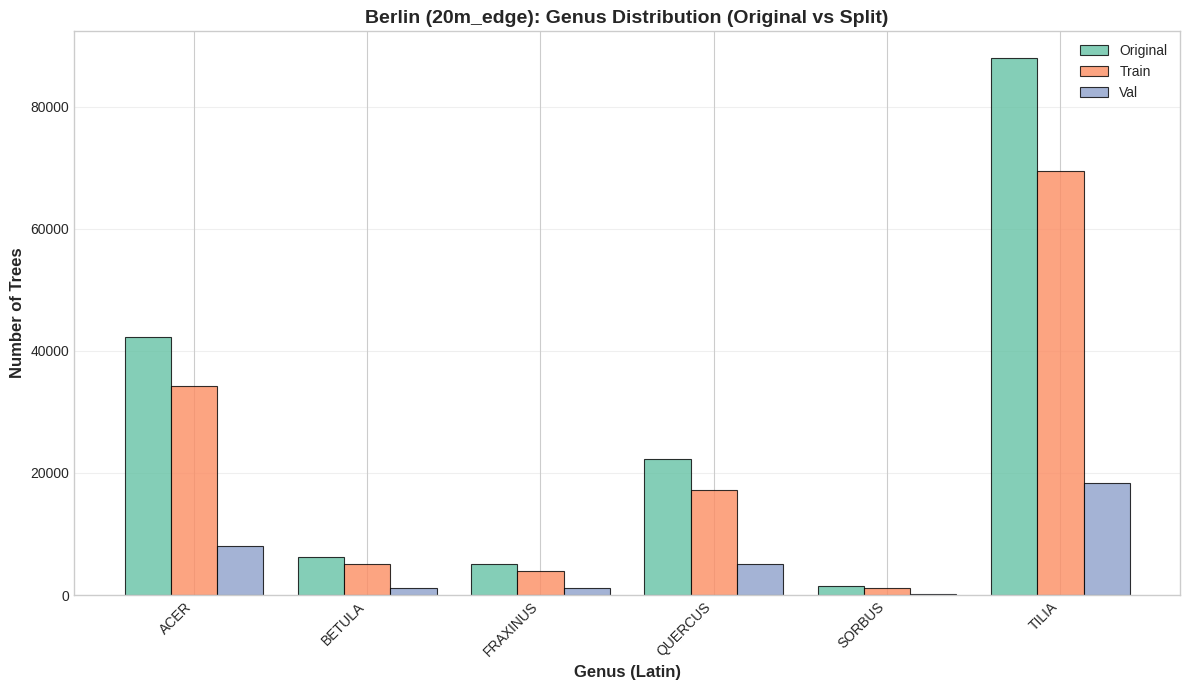

In [18]:
# Visualization 2: Berlin Class Balance
variant = '20m_edge' # Assuming we stick to one variant for viz or use loop

if f'Berlin_{variant}_train' in splits:
    original_gdf = trees[variant]['Berlin']

    fig = plot_genus_distribution(
        {
            'Original': original_gdf,
            'Train': splits[f'Berlin_{variant}_train'],
            'Val': splits[f'Berlin_{variant}_val']
        },
        GENERA_PER_VARIANT[variant],
        f'Berlin ({variant}): Genus Distribution (Original vs Split)'
    )
    plt.savefig(PLOTS_DIR / f'berlin_{variant}_class_balance.png', bbox_inches='tight')
    plt.show()

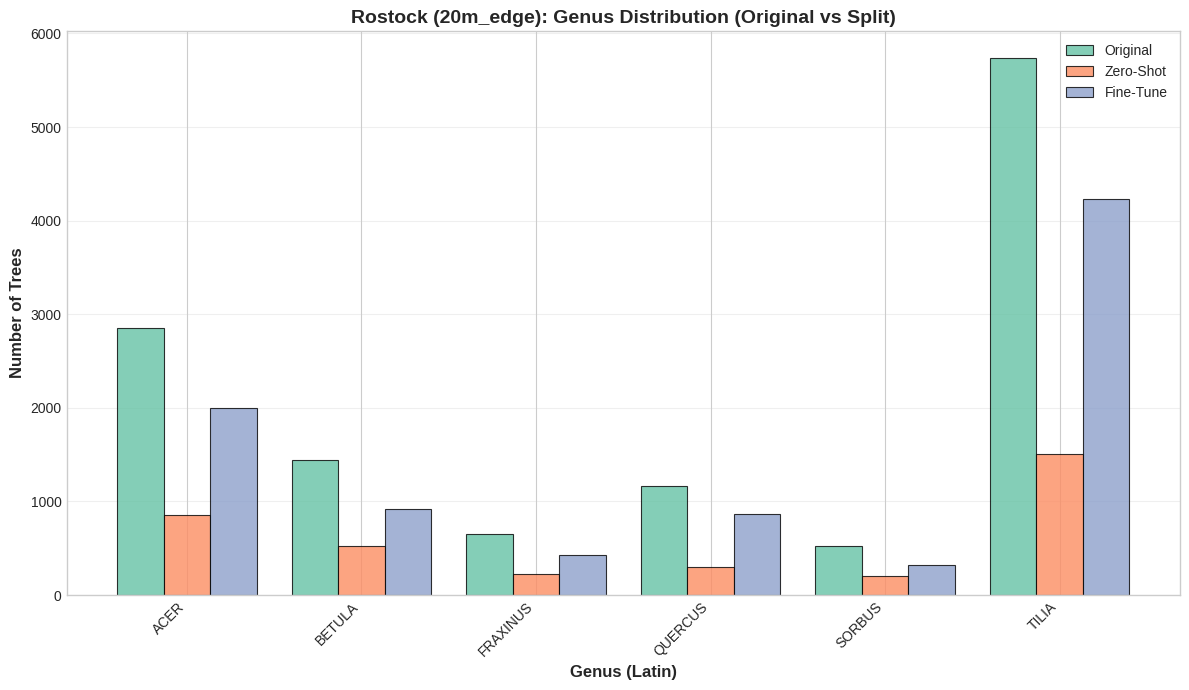

In [19]:
# Visualization 3: Rostock Class Balance
variant = '20m_edge'

if f'rostock_{variant}_zero_shot' in splits:
    original_gdf = trees[variant]['Rostock']

    fig = plot_genus_distribution(
        {
            'Original': original_gdf,
            'Zero-Shot': splits[f'rostock_{variant}_zero_shot'],
            'Fine-Tune': splits[f'rostock_{variant}_finetune_eval']
        },
        GENERA_PER_VARIANT[variant],
        f'Rostock ({variant}): Genus Distribution (Original vs Split)'
    )
    plt.savefig(PLOTS_DIR / f'rostock_{variant}_class_balance.png', bbox_inches='tight')
    plt.show()

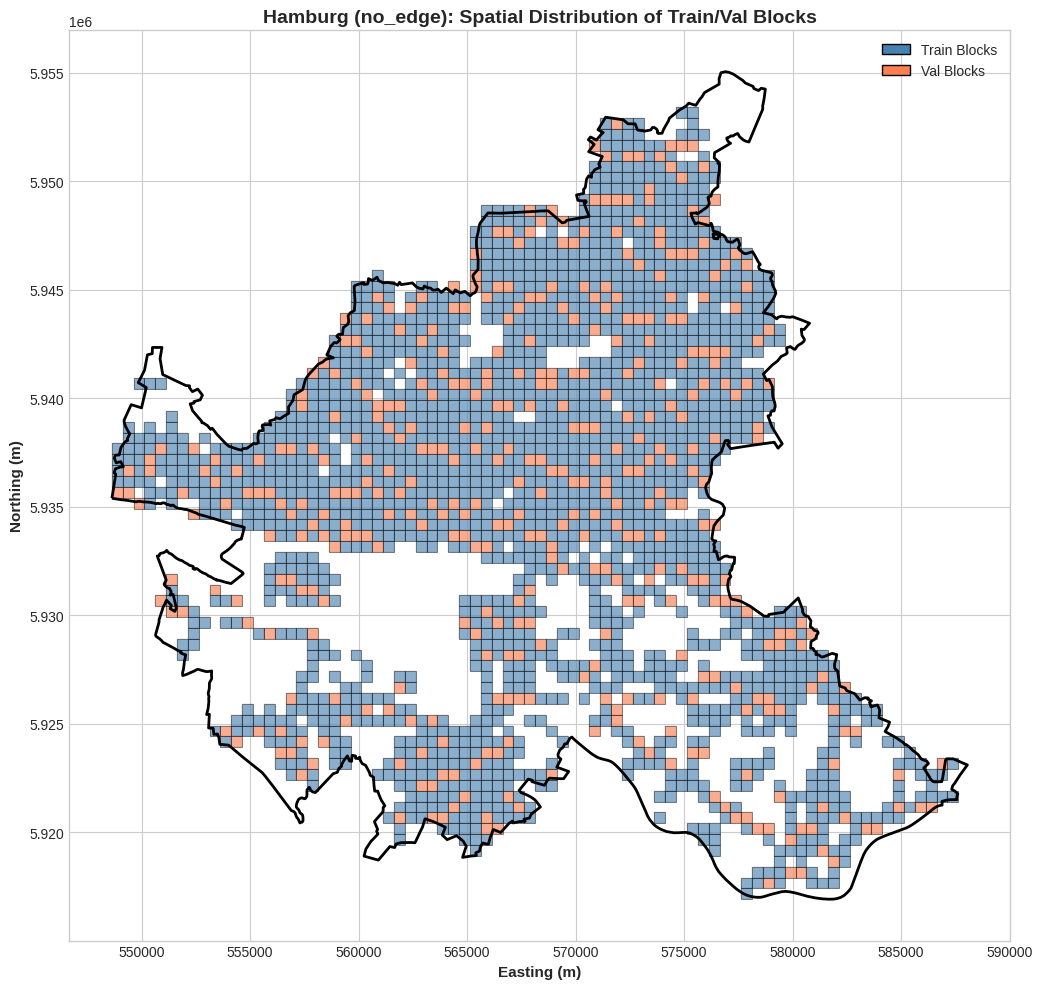

✓ Saved: hamburg_spatial_splits.png


In [22]:
# Visualization 4: Spatial distribution of splits (Hamburg example)
fig, ax = plt.subplots(figsize=(12, 10))

# We need to select a specific variant to visualize, e.g., 'no_edge'
viz_variant = 'no_edge'

if 'Hamburg' in blocks_gdf[viz_variant]:
    # Plot all blocks (background)
    blocks_gdf[viz_variant]['Hamburg'].plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.3, alpha=0.3)

    # Plot train/val splits with different colors
    # Keys: Hamburg_no_edge_train_blocks
    train_key = f'Hamburg_{viz_variant}_train_blocks'
    val_key = f'Hamburg_{viz_variant}_val_blocks'

    # OPTIMIZED: Use .isin() to select and plot all blocks at once instead of looping
    if train_key in splits:
        train_block_ids = splits[train_key]
        train_blocks = blocks_gdf[viz_variant]['Hamburg'][blocks_gdf[viz_variant]['Hamburg']['block_id'].isin(train_block_ids)]
        train_blocks.plot(ax=ax, color='steelblue', edgecolor='black', linewidth=0.5, alpha=0.6)

    if val_key in splits:
        val_block_ids = splits[val_key]
        val_blocks = blocks_gdf[viz_variant]['Hamburg'][blocks_gdf[viz_variant]['Hamburg']['block_id'].isin(val_block_ids)]
        val_blocks.plot(ax=ax, color='coral', edgecolor='black', linewidth=0.5, alpha=0.6)

# Add city boundary
hamburg_boundary = boundaries[boundaries['city'].str.contains('Hamburg', case=False, na=False)]
if len(hamburg_boundary) > 0:
    hamburg_boundary.boundary.plot(ax=ax, color='black', linewidth=2)

ax.set_title(f'Hamburg ({viz_variant}): Spatial Distribution of Train/Val Blocks', fontsize=14, weight='bold')
ax.set_xlabel('Easting (m)', fontsize=11, weight='bold')
ax.set_ylabel('Northing (m)', fontsize=11, weight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', edgecolor='black', label='Train Blocks'),
    Patch(facecolor='coral', edgecolor='black', label='Val Blocks')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'hamburg_spatial_splits.png',
            dpi=PUBLICATION_STYLE['dpi_export'], bbox_inches='tight')
plt.show()
print("✓ Saved: hamburg_spatial_splits.png")

---

## 7. SUMMARY & INSIGHTS

### 7.1 Key Findings

In [23]:
# Generate comprehensive summary
summary = {
    "configuration": {
        "block_size_m": BLOCK_SIZE_M,
        "train_split_ratio": TRAIN_SPLIT,
        "n_folds_sgkf": PROCESSING_PARAMS['n_folds'],
        "random_state": RANDOM_STATE,
    },
    "hamburg": {
        "train_trees": len(splits.get('Hamburg_no_edge_train', [])),
        "train_blocks": len(splits.get('Hamburg_no_edge_train_blocks', [])),
        "val_trees": len(splits.get('Hamburg_no_edge_val', [])),
        "val_blocks": len(splits.get('Hamburg_no_edge_val_blocks', [])),
    },
    "berlin": {
        "train_trees": len(splits.get('Berlin_no_edge_train', [])),
        "train_blocks": len(splits.get('Berlin_no_edge_train_blocks', [])),
        "val_trees": len(splits.get('Berlin_no_edge_val', [])),
        "val_blocks": len(splits.get('Berlin_no_edge_val_blocks', [])),
    },
    "rostock": {
        "zero_shot_trees": len(splits.get('rostock_no_edge_zero_shot', [])),
        "zero_shot_blocks": len(splits.get('rostock_no_edge_zs_blocks', [])),
        "finetune_eval_trees": len(splits.get('rostock_no_edge_finetune_eval', [])),
        "finetune_eval_blocks": len(splits.get('rostock_no_edge_ft_blocks', [])),
    },
    "total_blocks": len(block_assignments_df),
}

# Save summary
summary_path = METADATA_DIR / 'split_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print("\n" + "=" * 80)
print("PHASE 4 COMPLETE - KEY FINDINGS (No-Edge Variant)")
print("=" * 80)
print(json.dumps(summary, indent=2))
print("\n" + "=" * 80)
print(f"✓ Summary saved: {summary_path.name}")
print("=" * 80)

print("\nOutputs Created in 05_spatial_splits:")
print("  1. Data (GPKG files):")
print(f"     Location: {SPLITS_DATA_DIR}")
print("  2. Metadata (CSV/JSON):")
print(f"     Location: {METADATA_DIR}")
print("  3. Plots (PNG):")
print(f"     Location: {PLOTS_DIR}")


PHASE 4 COMPLETE - KEY FINDINGS (No-Edge Variant)
{
  "configuration": {
    "block_size_m": 500,
    "train_split_ratio": 0.8,
    "n_folds_sgkf": 5,
    "random_state": 42
  },
  "hamburg": {
    "train_trees": 70683,
    "train_blocks": 1675,
    "val_trees": 18513,
    "val_blocks": 420
  },
  "berlin": {
    "train_trees": 404497,
    "train_blocks": 2416,
    "val_trees": 105186,
    "val_blocks": 605
  },
  "rostock": {
    "zero_shot_trees": 9800,
    "zero_shot_blocks": 124,
    "finetune_eval_trees": 27009,
    "finetune_eval_blocks": 290
  },
  "total_blocks": 10827
}

✓ Summary saved: split_summary.json

Outputs Created in 05_spatial_splits:
  1. Data (GPKG files):
     Location: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/data
  2. Metadata (CSV/JSON):
     Location: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/metadata
  3. Plots (PNG):
     Location: /conte

---

**Notebook End**

Exported: 2025-01-12

Author: Silas Pignotti